# Dynamic graph CNNs project
Presentation of this paper : https://arxiv.org/abs/1801.07829 by Wang,Sun (2018), as part of the class *Geometric Data Analysis* by Jean Feydy.
The task is to classify and segment point clouds belonging to the ModelNet40 classification dataset and the ShapeNet segmentation dataset.


## Import Data
Import the modelnet40_ply_hdf5_2048 dataset and visiualize some samples

In [1]:
from google.colab import userdata
GTOKEN = userdata.get('GITHUB')

#Code was mostly adapted from https://github.com/WangYueFt/dgcnn, and updated
# by https://www.github.com/matthieuml. I just added some robustness tests and
# data manipulations to test the model.

! git clone https://$GTOKEN@github.com/matthieuml/DGCNN.git


fatal: destination path 'DGCNN' already exists and is not an empty directory.


In [2]:
import os
os.chdir("DGCNN/src")

In [3]:
# Always reload in jupyter notebook
%load_ext autoreload
%autoreload 2

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from dgcnn.data import ModelNet40, load_data_cls as load_data
from dgcnn.model import PointNet, DGCNN
from torch.utils.data import DataLoader
from dgcnn.util import cal_loss, IOStream
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from importlib import reload


In [4]:
X_train, y_train = load_data('train')
X_test, y_test = load_data('test')
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(9840, 2048, 3) (9840, 1)
(2468, 2048, 3) (2468, 1)


## 1) Data manipulations

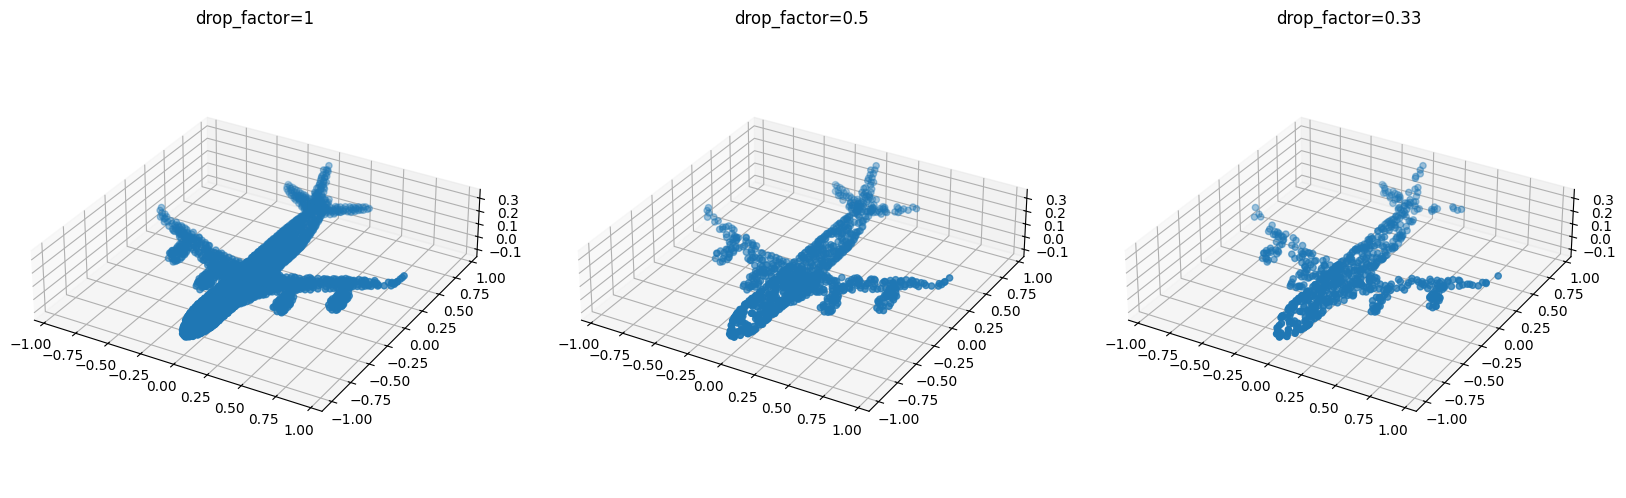

In [5]:
# drop half of the points to make inhomogeneous regions

def drop_points(X: np.array, drop_rate: float):
  """
    Drops a proportion of the  points for each point cloud of the dataset X.

  """

  n_points = X.shape[1]
  new_n_points = int(n_points*drop_rate)

  X_dropped = []

  for k in range(len(X)):
    ind = np.random.choice(range(n_points),size=new_n_points,replace=False)
    X_dropped.append(X[k][ind])

  return np.array(X_dropped)


factors = [1,0.5,0.33]
fig, axes = plt.subplots(1, len(factors), figsize=(20, 15), subplot_kw={'projection': '3d'})

for i, drop_factor in enumerate(factors):
  id = 7

  X_dropped = drop_points(X_train[:10], drop_factor)

  axes[i].scatter(X_dropped[id][:, 0], X_dropped[id][:, 2], X_dropped[id][:, 1])
  axes[i].set_aspect('equal', adjustable='box')
  axes[i].set_title(f"{drop_factor=}")


# Display the plot
plt.show()


Plot one sample

In [6]:
!pip install open3d

### Handcrafted geometrical features
In previous papers, these features were pre-computed in order to be fed as input to a deep model. With PointNet and DGCNN, the idea was instead to use the raw point cloud as input and to learn the features during training.

We will compute the voxelization and the normals of an example point cloud in order to illustrate this. As we can see, computing normals takes around 10ms for a single point cloud of size 2024 (on a CPU from google colab).

8.47 ms ± 59.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


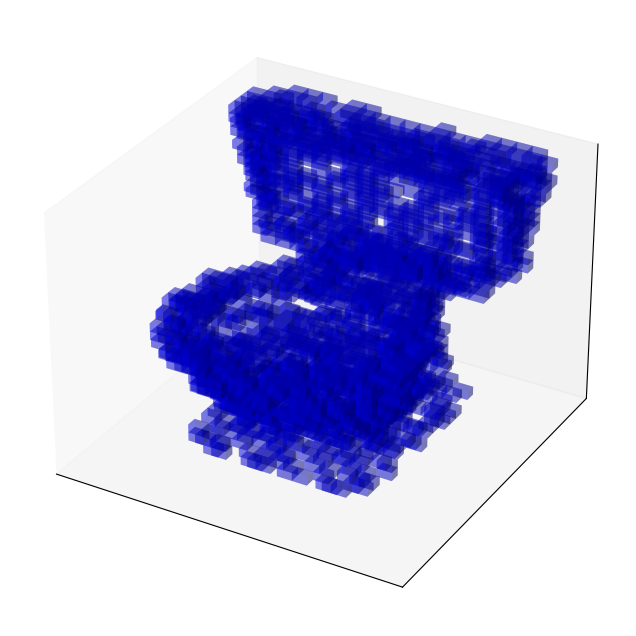

Voxel (-3, -10, -15) contains 1 points
Voxel (-3, 0, -2) contains 2 points
Voxel (-5, 9, 10) contains 1 points
Voxel (-5, -4, -5) contains 2 points
Voxel (2, 1, -8) contains 1 points


In [8]:
import open3d as o3d

points_np = X_test[7].copy()
points_np[:,2],points_np[:,1] = points_np[:,1],points_np[:,2].copy()

# Create an Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_np)

# Estimate normals
%timeit pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Visualize the point cloud with normals
# o3d.visualization.draw_geometries([pcd]) does not work in colab ; use plt.quiver
normals_np = np.asarray(pcd.normals)

voxel_size = 0.05
voxel_indices = np.floor(points_np / voxel_size).astype(int)
voxel_dict = {}

for point, voxel_idx in zip(points_np, voxel_indices):
    voxel_key = tuple(voxel_idx)
    if voxel_key not in voxel_dict:
        voxel_dict[voxel_key] = []
    voxel_dict[voxel_key].append(point)

# Create the 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Loop through the voxels and plot cubes at the voxel positions
for voxel_key in voxel_dict:
    # Each voxel will be a small cube, with its bottom corner at the voxel position
    x, y, z = voxel_key
    ax.bar3d(voxel_size*x, voxel_size*y, voxel_size*z, voxel_size, voxel_size, voxel_size, color='blue', alpha=0.3)

ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])


# Show the plot
plt.show()


# Example: printing the first few voxels
for voxel_key, voxel_points in list(voxel_dict.items())[:5]:
    print(f"Voxel {voxel_key} contains {len(voxel_points)} points")


## Using a pretrained DGCNN model

In [9]:
model = DGCNN(k=40, emb_dims=1024, dropout=0.5)
state_dict = torch.load('dgcnn/pretrained/model.1024.t7', weights_only=True)
# Convert all keys from module.bn1.weight to bn1.weight
state_dict = {k[7:]: v for k, v in state_dict.items()}
model.load_state_dict(state_dict)
model = nn.DataParallel(model)
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

DataParallel(
  (module): DGCNN(
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Sequential(
      (0): Conv2d(6, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv2): Sequential(
      (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (conv3): Sequential(
      (0): 

### Testing the claim that DGCNN is faster than PointNet on 1000 clouds

The authors probably meant PointNet++, as the PointNet model is faster in our tests. We use a random initialization for PointNet as we do not have the pretrained weights and do not want to retrain it from scratch. We only care about the inference time.

In [15]:
from time import time
preds = []

loader = DataLoader(X_train[:1000],batch_size=2)
start_time = time()

for cloud in loader:
  test_x = torch.Tensor(cloud).to("cuda").permute(0, 2, 1)
  class_vector = model(test_x,return_idx=True)[0].cpu().detach().numpy()

  #not sure why I need to clean memory manually, but it fills up otherwise
  del test_x
  torch.cuda.empty_cache()

  preds.extend(np.argmax(class_vector,axis=-1))
dgcnn_time = time() - start_time

model_ptnet = PointNet(1024).to("cuda")

start_time = time()
for cloud in loader:

  test_x = torch.Tensor(cloud).to("cuda").permute(0, 2, 1)
  class_vector = model_ptnet(test_x).cpu()
  del test_x
  torch.cuda.empty_cache()

pointnet_time = time() - start_time
print(f"dgcnn time: {dgcnn_time}")
print(metrics.accuracy_score(y_train[:1000], preds))
print(f"DGCNN inference time: {dgcnn_time:.4f} seconds")
print(f"PointNet inference time: {pointnet_time:.4f} seconds")


dgcnn time: 52.921550273895264
0.99
DGCNN inference time: 52.9216 seconds
PointNet inference time: 2.0041 seconds


### Testing the robustness of a model trained on a fixed number of points to dropout

We will reduce the number of points and see the impact on accuracy.

In [21]:
from tqdm import tqdm

drop_factors = [.4,.5,.6,.7,.8,.9,1]
n_clouds = -1
accuracies = []

for drop_factor in drop_factors:
  X_test, y_test = load_data('test')
  X_test = drop_points(X_test, drop_factor)

  preds = []
  loader = DataLoader(X_test[:n_clouds],batch_size=8)
  for cloud in tqdm(loader):
    test_x = torch.Tensor(cloud).type(torch.float32).to("cuda").permute(0, 2, 1)
    class_vector = model(test_x,return_idx=True)[0].detach().cpu().numpy()
    preds.extend(np.argmax(class_vector,axis=-1))

    del test_x
    torch.cuda.empty_cache()


  accuracies.append(metrics.accuracy_score(y_test[:n_clouds], preds))

print([f"{drop_rate=}:{accuracy=}" for drop_rate,accuracy in zip(drop_factors,accuracies)])

100%|██████████| 309/309 [01:33<00:00,  3.30it/s]

['drop_rate=0.4:accuracy=0.766518038102959', 'drop_rate=0.5:accuracy=0.8439400081070125', 'drop_rate=0.6:accuracy=0.8824483177948926', 'drop_rate=0.7:accuracy=0.9079854073773814', 'drop_rate=0.8:accuracy=0.9185245237130117', 'drop_rate=0.9:accuracy=0.9177138224564249', 'drop_rate=1:accuracy=0.9266315362788813']


Text(0, 0.5, 'accuracy')

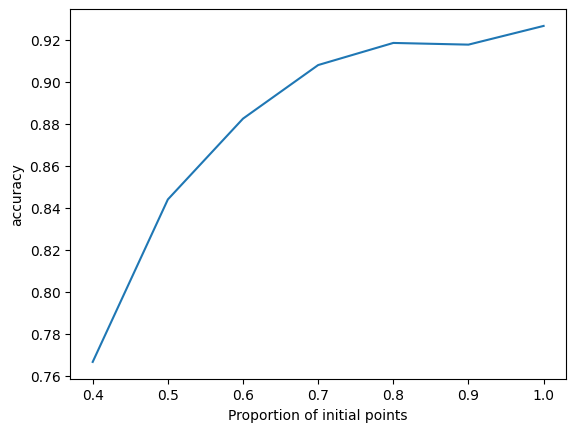

In [22]:
plt.plot(drop_factors,accuracies)
plt.xlabel("Proportion of initial points")
plt.ylabel("accuracy")